<a href="https://colab.research.google.com/github/wallinsonsilva/ciencia_de_dados_covid/blob/master/AnaliseApresentacaoDadosCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Este Colab tem como propósito explorar, analisar e apresentar os dados de contágio e óbitos por Covid-19 no estado do Rio Grande do Norte, e relacionar tais ocorrêsncias com fatores socioeconômicos.

Após as análises feitas identificamos as variáveis que mais agregaram valor a este trabalho e realizamos os seguintes relacionamentos:
- CIR's (Regiões de Saúde do RN) x Porcentagem de Óbitos.
- (Riqueza e Probreza) x Taxa de Contágia da População por Município;
- (Riqueza e Probreza) x Taxa de Óbitos da População por Município;
- (IDHM e GeoSES) x Taxa de Contágia da População por Município;
- (IDHM e GeoSES) x Taxa de Óbitos da População por Município;

In [164]:
#hide
!pip install plotly==4.9.0

In [165]:
#hide
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import plotly
import plotly.express as px
import requests
import datetime
import json
from urllib.error import HTTPError
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [166]:
#hide
print(plotly.__version__)

4.9.0


O dataset utilizado para este trabalho é o resultado do join dos datasets de histórico de casos de Covid-19 no Brasil (apenas os dados do RN foram utilizados), GeoSES, Dados socioeconômicos do IBGE (2017) e Regiões de Saúde do Rio Grande do Norte (confecção manual).

In [167]:
#hide
#Lendo o arquivo do Git, mas o arquivo está sendo gerado em um outro colab.
dados = pd.read_csv('https://raw.githubusercontent.com/wallinsonsilva/ciencia_de_dados_covid/master/ET_dados_casos_mun_reg_igbe_geoses.csv')
dados.head()

,codmun,municipio,codRegiaoSaude,nomeRegiaoSaude,populacaoTCU2019,casosAcumulado,obitosAcumulado,porcentagem_casos_hab,porcentagem_obitos_casos,CIR,CodRegiao,Sede,Região de Saúde,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Código Município,Código Município Completo,Municipio,CodMunIBGE,Código,Área Territorial - km²,População estimada - pessoas,Densidade demográfica - hab/km²,Escolarização 6 a 14 anos,IDHM - Índice de desenvolvimento humano municipal,Mortalidade infantil - óbitos por mil nascidos vivos,Receitas realizadas - R$ (×1000),Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$,v0002_codigo_do_municipio,GeoSES,educação,mobilidade,pobreza,privacao_material,riqueza,renda,segregacao
0,240010,Acari,24004,4ª REGIAO DE SAUDE - CAICO,11136,61,3,0.005478,0.049180,4,24004,Caicó,Seridó,2,Central Potiguar,12,Seridó Oriental,109.0,2400109,Acari,240010,2400109,608.466,11136,18.13,97.6,0.679,19.05,26943.45359,23825.10614,10508.72,2400109,-0.410797,65.097671,0,49.797160,10.669699,1.578662,1455.053300,0.122580
1,240020,Açu,24008,8ª REGIAO DE SAUDE - ACU,58017,1167,51,0.020115,0.043702,8,24008,Açu,Vale do Açu,1,Oeste Potiguar,4,Vale do Açu,208.0,2400208,Açu,240020,2400208,1303.442,58017,40.84,97.6,0.661,8.08,107791.03530,98919.77871,15364.85,2400208,-0.437745,67.174991,0,52.981741,15.582068,1.099616,1646.173817,0.075290
2,240030,Afonso Bezerra,24003,3ª REGIAO DE SAUDE - JOAO CAMARA,11035,101,6,0.009153,0.059406,3,24003,João Câmara,Mato Grande/Salineira,2,Central Potiguar,9,Angicos,307.0,2400307,Afonso Bezerra,240030,2400307,576.179,11035,18.82,98.8,0.585,9.01,33903.89094,34590.47519,8556.54,2400307,-0.649073,75.243551,0,67.967307,11.348408,0.000000,984.783786,0.060091
3,240040,Água Nova,24006,6ª REGIAO DE SAUDE - PAU DOS FERROS,3252,20,0,0.006150,0.000000,6,24006,Pau dos Ferros,Alto Oeste,1,Oeste Potiguar,5,Serra de São Miguel,406.0,2400406,Água Nova,240040,2400406,50.684,3252,58.80,99.2,0.616,19.61,14214.25207,14059.26223,7818.76,2400406,-0.631610,67.334670,0,74.989196,2.671361,0.000000,798.149419,0.081219
4,240050,Alexandria,24006,6ª REGIAO DE SAUDE - PAU DOS FERROS,13577,44,4,0.003241,0.090909,6,24006,Pau dos Ferros,Alto Oeste,1,Oeste Potiguar,6,Pau dos Ferros,505.0,2400505,Alexandria,240050,2400505,381.205,13577,35.43,97.5,0.606,11.76,44435.81559,42149.27432,9054.32,2400505,-0.568943,74.495238,0,63.870020,6.178090,0.910539,1064.850212,0.085320


In [168]:
#hide
#Coluna e tipo de dados do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 40 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   codmun                                                167 non-null    int64  
 1   municipio                                             167 non-null    object 
 2   codRegiaoSaude                                        167 non-null    int64  
 3   nomeRegiaoSaude                                       167 non-null    object 
 4   populacaoTCU2019                                      167 non-null    int64  
 5   casosAcumulado                                        167 non-null    int64  
 6   obitosAcumulado                                       167 non-null    int64  
 7   porcentagem_casos_hab                                 167 non-null    float64
 8   porcentagem_obitos_casos                              167 no

Text(0.5, 0, 'Distribuição da Quantidade de Casos Por Municipio')

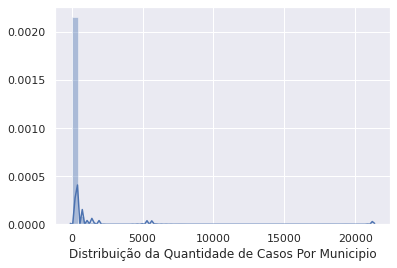

In [169]:
#@title
#hide_input

#Distribuição da quantidade de casos por município. Boa parte municípios apresentam uma quantidade de casos semelhantes.
sns.distplot(dados["casosAcumulado"])
plt.xlabel('Distribuição da Quantidade de Casos Por Municipio')

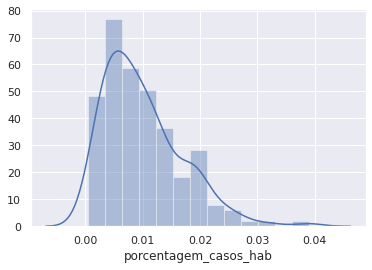

In [170]:
#hide_input

sns.distplot(dados["porcentagem_casos_hab"])

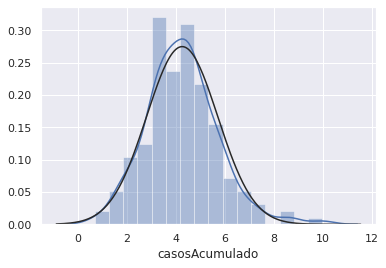

In [171]:
#hide_input

#Logaritimo dos casosAcumulado e a exibição dos dados de forma normalizada
casos_log = np.log(dados["casosAcumulado"])
sns.distplot(casos_log,fit=norm)

### Correlação entre o tamanho da população e a quantidade de casos acumulados

In [172]:
#hide
# Relacionamento entre o tamanho da população e a quantidade de casos.
populacao_casoacumulado = dados.loc[:,['populacaoTCU2019','casosAcumulado']]
populacao_casoacumulado.corr()

,populacaoTCU2019,casosAcumulado
populacaoTCU2019,1.000000,0.993275
casosAcumulado,0.993275,1.000000


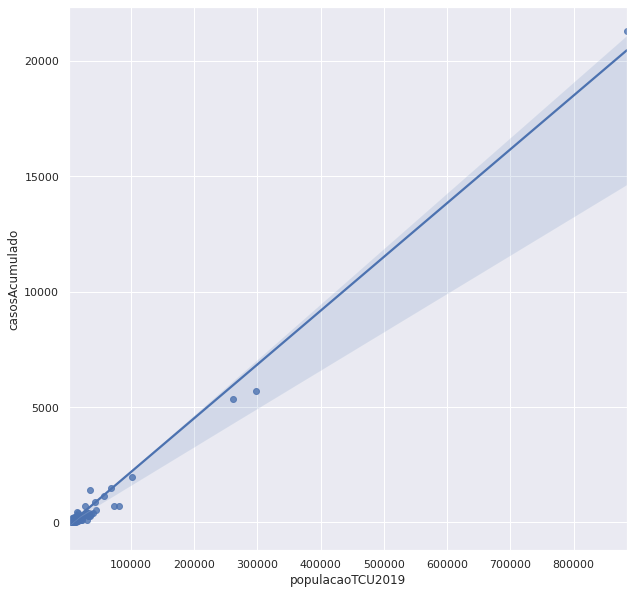

In [173]:
#hide_input

plt.figure(figsize=(10, 10))
sns.regplot(x="populacaoTCU2019", y="casosAcumulado", data=populacao_casoacumulado,label="Relação da Quantidade de Casos com o Tamanho da População")
plt.show()

<BarContainer object of 5 artists>

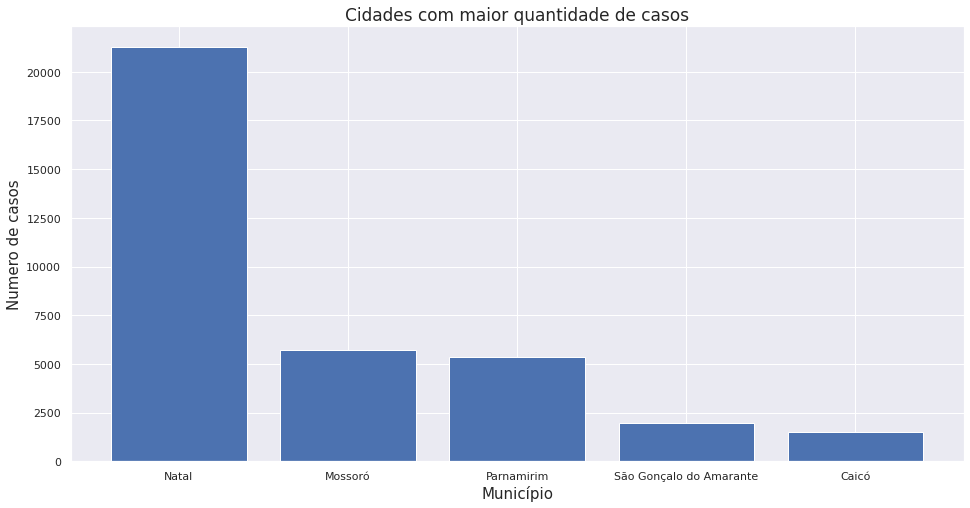

In [174]:
#hide_input

maiores = dados.nlargest(5,'casosAcumulado')
plt.figure(figsize=(16,8))
plt.title("Cidades com maior quantidade de casos", fontsize=17 )
plt.xlabel("Município", fontsize=15)
plt.ylabel("Numero de casos", fontsize=15)
plt.bar(maiores['municipio'],maiores['casosAcumulado'])

<BarContainer object of 5 artists>

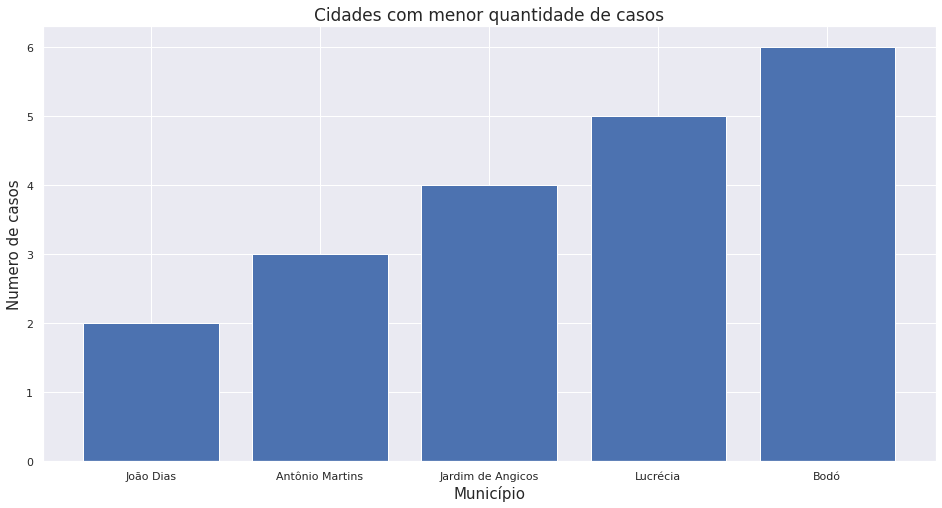

In [175]:
#hide_input

menores = dados.nsmallest(5,'casosAcumulado')
plt.figure(figsize=(16,8))
plt.title("Cidades com menor quantidade de casos", fontsize=17)
plt.xlabel("Município", fontsize=15)
plt.ylabel("Numero de casos", fontsize=15)
plt.bar(menores['municipio'],menores['casosAcumulado'])

## Regiões de Saúde do RN com maior taxa de óbitos.

In [176]:
#hide_input

#Quantidade de casos e óbitos por região de saúde do RN
casos_regiao = pd.pivot_table(dados, index=['CIR','nomeRegiaoSaude'],values=['casosAcumulado','obitosAcumulado'],aggfunc=np.sum)
casos_regiao['porcentagem_obito'] = (casos_regiao['obitosAcumulado'] / casos_regiao['casosAcumulado'])*100
casos_regiao = casos_regiao.reset_index()
casos_regiao

,CIR,nomeRegiaoSaude,casosAcumulado,obitosAcumulado,porcentagem_obito
0,1,1ª REGIAO DE SAUDE - SAO JOSE DE MIPIBU,4526,133,2.938577
1,2,2ª REGIAO DE SAUDE - MOSSORO,9443,308,3.261675
2,3,3ª REGIAO DE SAUDE - JOAO CAMARA,3762,133,3.535354
3,4,4ª REGIAO DE SAUDE - CAICO,3726,73,1.959206
4,5,5ª REGIAO DE SAUDE - SANTA CRUZ,2120,60,2.830189
5,6,6ª REGIAO DE SAUDE - PAU DOS FERROS,1030,36,3.495146
6,7,7ª REGIAO DE SAUDE - METROPOLITANA,29774,1184,3.976624
7,8,8ª REGIAO DE SAUDE - ACU,2691,109,4.050539


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

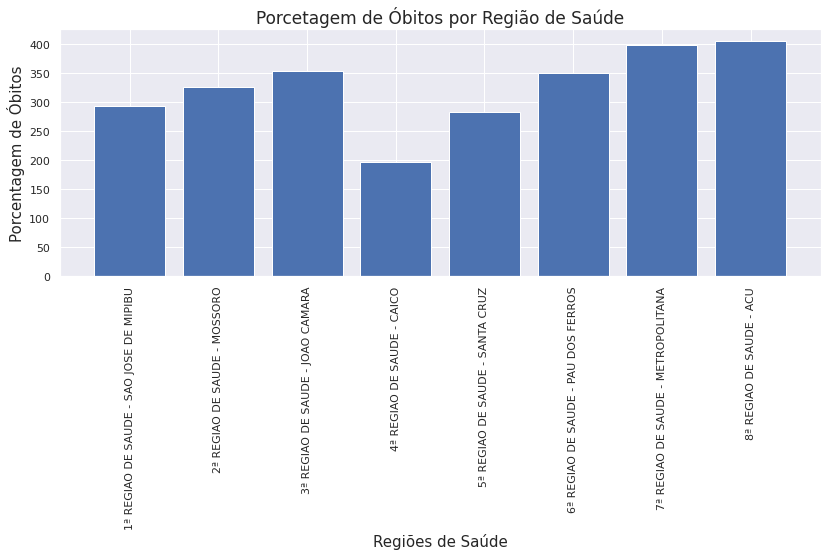

In [177]:
#hide_input

plt.figure(figsize=(30,10))
plt.subplot(221)
plt.bar(casos_regiao['nomeRegiaoSaude'],casos_regiao['porcentagem_obito']*100)
plt.title('Porcetagem de Óbitos por Região de Saúde', fontsize=17)
plt.ylabel('Porcentagem de Óbitos', fontsize=15)
plt.xlabel('Regiões de Saúde', fontsize=15)
plt.xticks(rotation=90)

In [178]:
#hide
#Agrupamento dos dados de cada um dos municípios e com informações relevantes do Dataset do GeoSES
principais_dados = dados[['codmun','municipio','CIR','populacaoTCU2019','casosAcumulado','obitosAcumulado',
                                              'IDHM - Índice de desenvolvimento humano municipal',
                                              'PIB per capita - R$','Código Município Completo','GeoSES','pobreza',
                                              'riqueza','nomeRegiaoSaude']]
principais_dados['porcentagem_obito'] = (principais_dados['obitosAcumulado'] / principais_dados['casosAcumulado']) * 100
principais_dados['porcent_pop_contagiada'] = (principais_dados['casosAcumulado'] / principais_dados['populacaoTCU2019']) * 100
principais_dados.rename(columns={'IDHM - Índice de desenvolvimento humano municipal':'IDHM'}, inplace=True)
principais_dados

,codmun,municipio,CIR,populacaoTCU2019,casosAcumulado,obitosAcumulado,IDHM,PIB per capita - R$,Código Município Completo,GeoSES,pobreza,riqueza,nomeRegiaoSaude,porcentagem_obito,porcent_pop_contagiada
0,240010,Acari,4,11136,61,3,0.679,10508.72,2400109,-0.410797,49.797160,1.578662,4ª REGIAO DE SAUDE - CAICO,4.918033,0.547773
1,240020,Açu,8,58017,1167,51,0.661,15364.85,2400208,-0.437745,52.981741,1.099616,8ª REGIAO DE SAUDE - ACU,4.370180,2.011479
2,240030,Afonso Bezerra,3,11035,101,6,0.585,8556.54,2400307,-0.649073,67.967307,0.000000,3ª REGIAO DE SAUDE - JOAO CAMARA,5.940594,0.915270
3,240040,Água Nova,6,3252,20,0,0.616,7818.76,2400406,-0.631610,74.989196,0.000000,6ª REGIAO DE SAUDE - PAU DOS FERROS,0.000000,0.615006
4,240050,Alexandria,6,13577,44,4,0.606,9054.32,2400505,-0.568943,63.870020,0.910539,6ª REGIAO DE SAUDE - PAU DOS FERROS,9.090909,0.324077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,241470,Várzea,1,5500,81,5,0.626,7528.24,2414704,-0.622945,63.197393,0.433516,1ª REGIAO DE SAUDE - SAO JOSE DE MIPIBU,6.172840,1.472727
163,241475,Venha-Ver,6,4177,8,3,0.555,8516.06,2414753,-0.659560,78.069265,0.000000,6ª REGIAO DE SAUDE - PAU DOS FERROS,37.500000,0.191525
164,241480,Vera Cruz,1,12481,119,6,0.587,8627.61,2414803,-0.637931,65.515705,0.147214,1ª REGIAO DE SAUDE - SAO JOSE DE MIPIBU,5.042017,0.953449
165,241490,Viçosa,6,1718,9,0,0.592,9109.95,2414902,-0.639707,69.465805,0.000000,6ª REGIAO DE SAUDE - PAU DOS FERROS,0.000000,0.523865


In [179]:
#hide
#Seleção de dados
principais_dados = principais_dados[
                 ['codmun','Código Município Completo','municipio','IDHM','GeoSES','pobreza','casosAcumulado','obitosAcumulado','riqueza','porcentagem_obito','porcent_pop_contagiada','CIR','nomeRegiaoSaude']
                 ]

## Relação de Riqueza e Pobreza com a Porcentagem de Contágio da População por Município

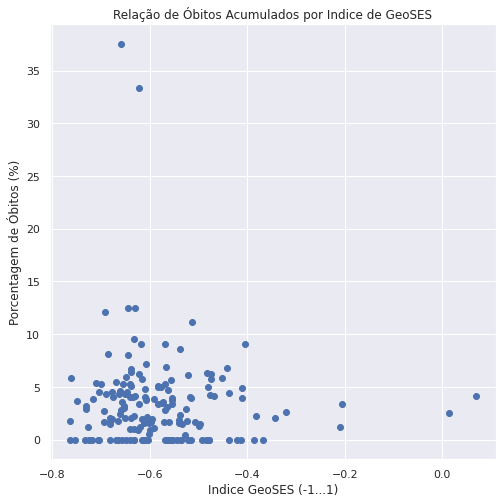

In [180]:
#hide_input

x = "GeoSES"
y = "porcentagem_obito"
populacao_casoacumulado = principais_dados.loc[:,[x,y]]
plt.figure(figsize=(8, 8))
plt.scatter(x=x, y=y, data=populacao_casoacumulado)
plt.xlabel("Indice GeoSES (-1...1)")
plt.ylabel("Porcentagem de Óbitos (%)")
plt.title('Relação de Óbitos Acumulados por Indice de GeoSES')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem da População por Município Contagiada (%)')

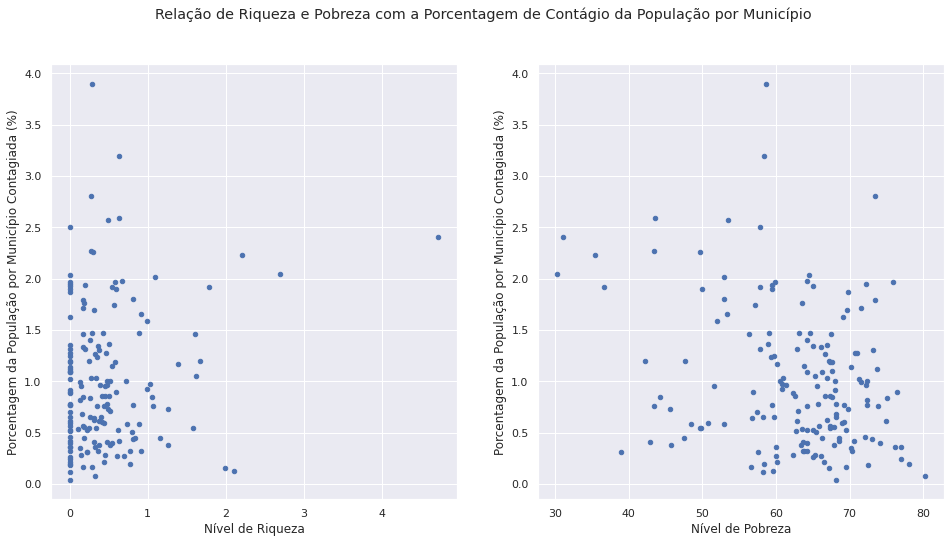

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [181]:
#hide_input

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação de Riqueza e Pobreza com a Porcentagem de Contágio da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "riqueza"
x2 = "pobreza"
y = "porcent_pop_contagiada"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Nível de Riqueza')
ax1.set_ylabel('Porcentagem da População por Município Contagiada (%)')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Nível de Pobreza')
ax2.set_ylabel('Porcentagem da População por Município Contagiada (%)')

In [182]:
#hide_input

fig = px.scatter(principais_dados, x="pobreza", y="porcent_pop_contagiada", color='municipio',
                 title="Relaçao da Porcentagem da População Contagiada com Covid com o Indice de Pobreza",
                 labels={'pobreza':'Indice de Pobreza (Quanto maior pior)',
                         'porcent_pop_contagiada':'Porcentagem de habitantes contagiados por município (%)',
                         'municipio':'Município'})
fig.show()

## Relação de Riqueza e Pobreza com a Porcentagem de Óbitos da População por Município

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem de Óbito da População por Município Contagiada (%)')

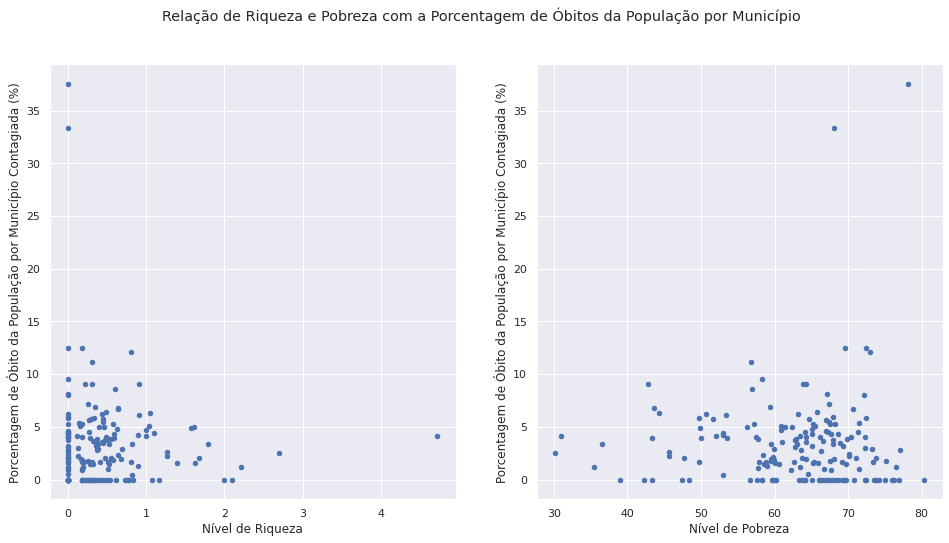

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [183]:
#hide_input

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação de Riqueza e Pobreza com a Porcentagem de Óbitos da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "riqueza"
x2 = "pobreza"
y = "porcentagem_obito"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Nível de Riqueza')
ax1.set_ylabel('Porcentagem de Óbito da População por Município Contagiada (%)')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Nível de Pobreza')
ax2.set_ylabel('Porcentagem de Óbito da População por Município Contagiada (%)')

In [184]:
#hide_input

fig = px.scatter(principais_dados, x="pobreza", y="porcentagem_obito", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'pobreza':'Indice de Pobreza (Quanto maior pior)',
                         'porcentagem_obito':'Porcentagem de óbito por município (%)',
                         'municipio':'Município'})
fig.show()

## Relação dos Indices de IDHM e GeoSES com a Porcentagem de Contágio da População por Município

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem da População por Município Contagiada')

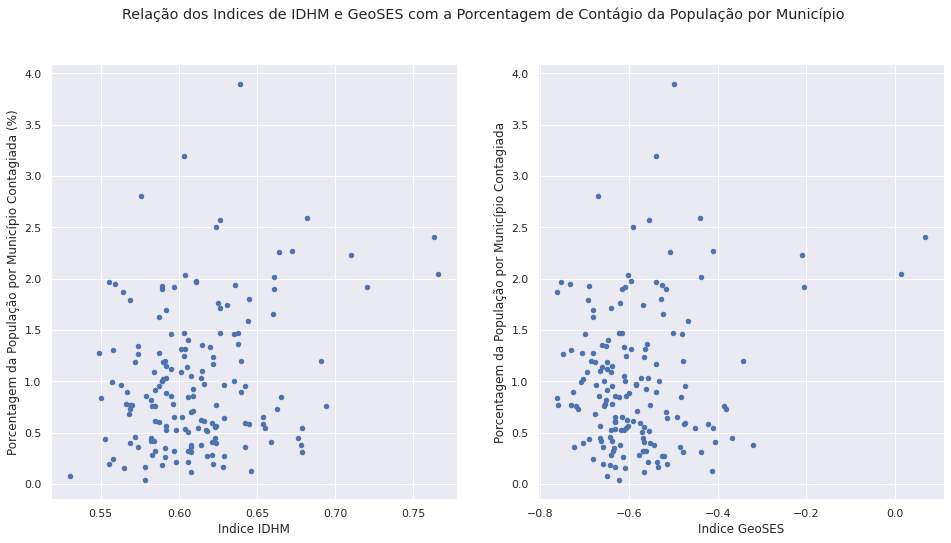

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [185]:
#hide_input

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação dos Indices de IDHM e GeoSES com a Porcentagem de Contágio da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "IDHM"
x2 = "GeoSES"
y = "porcent_pop_contagiada"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Indice IDHM')
ax1.set_ylabel('Porcentagem da População por Município Contagiada (%)')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Indice GeoSES')
ax2.set_ylabel('Porcentagem da População por Município Contagiada')

In [186]:
#hide_input

fig = px.scatter(principais_dados, x="IDHM", y="porcent_pop_contagiada", color='municipio',
                 title="Relaçao da Porcentagem de Contágio por Covid com o Indice de Pobreza",
                 labels={'IDHM':'IDHM - Indice de Desenvolvimento Humano - Municipal',
                         'porcent_pop_contagiada':'Porcentagem de óbito por município (%)',
                         'municipio':'Município'})
fig.show()

In [187]:
#hide_input

fig = px.scatter(principais_dados, x="GeoSES", y="porcent_pop_contagiada", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'GeoSES':'GeoSES - Índice Socioeconômico do Contexto Geográfico para Estudos em Saúde',
                         'porcent_pop_contagiada':'Porcentagem de óbito por município (%)',
                         'municipio':'Município'})
fig.show()

## Relação dos Indices de IDHM e GeoSES com a Porcentagem de Óbito da População por Município

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem da População por Município Contagiada (%)')

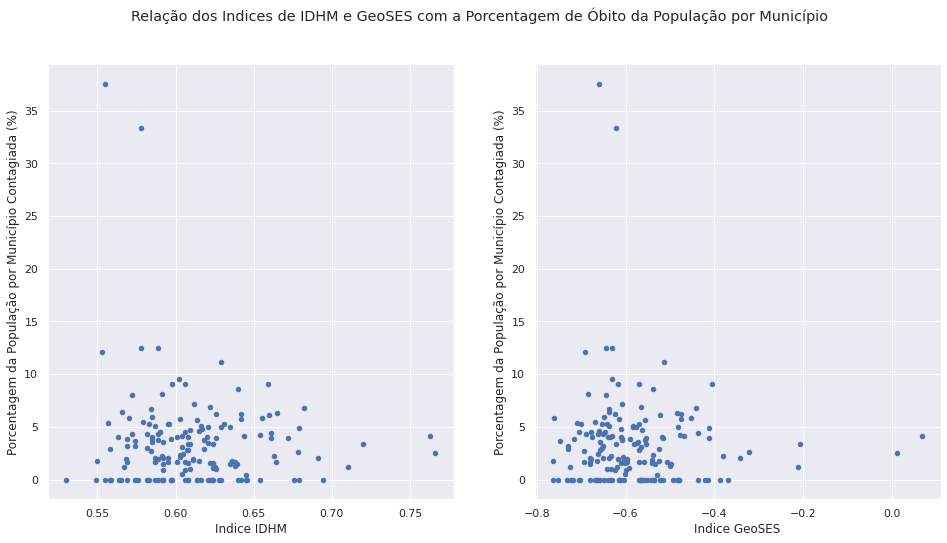

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [188]:
#hide_input

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação dos Indices de IDHM e GeoSES com a Porcentagem de Óbito da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "IDHM"
x2 = "GeoSES"
y = "porcentagem_obito"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Indice IDHM')
ax1.set_ylabel('Porcentagem da População por Município Contagiada (%)')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Indice GeoSES')
ax2.set_ylabel('Porcentagem da População por Município Contagiada (%)')

In [189]:
#hide_input

fig = px.scatter(principais_dados, x="IDHM", y="porcentagem_obito", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'IDHM':'IDHM - Indice de Desenvolvimento Humano - Municipal',
                         'porcentagem_obito':'Porcentagem de óbito por município (%)',
                         'municipio':'Município'})
fig.show()

In [190]:
#hide_input

fig = px.scatter(principais_dados, x="GeoSES", y="porcentagem_obito", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'GeoSES':'GeoSES - Índice Socioeconômico do Contexto Geográfico para Estudos em Saúde',
                         'porcentagem_obito':'Porcentagem de óbito por município (%)',
                         'municipio':'Município'})
fig.show()

In [191]:
#hide
rn = requests.get("https://servicodados.ibge.gov.br/api/v2/malhas/24/?formato=application/vnd.geo+json&resolucao=5").json()

In [192]:
#hide
principais_dados.rename(columns={'Código Município Completo':'codMunIBGE'},inplace=True)
principais_dados.codMunIBGE = principais_dados.codMunIBGE.astype(str)
principais_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   codmun                  167 non-null    int64  
 1   codMunIBGE              167 non-null    object 
 2   municipio               167 non-null    object 
 3   IDHM                    167 non-null    float64
 4   GeoSES                  167 non-null    float64
 5   pobreza                 167 non-null    float64
 6   casosAcumulado          167 non-null    int64  
 7   obitosAcumulado         167 non-null    int64  
 8   riqueza                 167 non-null    float64
 9   porcentagem_obito       167 non-null    float64
 10  porcent_pop_contagiada  167 non-null    float64
 11  CIR                     167 non-null    int64  
 12  nomeRegiaoSaude         167 non-null    object 
dtypes: float64(6), int64(4), object(3)
memory usage: 17.1+ KB


In [193]:
#hide_input

fig = px.choropleth(principais_dados, 
                    geojson=rn, 
                    color='porcentagem_obito',
                    locations='codMunIBGE',
                    hover_name="municipio",
                    hover_data=["casosAcumulado", "obitosAcumulado", "porcentagem_obito", "porcent_pop_contagiada","IDHM","GeoSES"],
                    featureidkey='properties.codarea',
                    center={"lat": -5.78362, "lon": -36.914},
                    color_continuous_scale='reds',
                    range_color=(0, principais_dados["porcentagem_obito"].max()),
                    labels={
                        "codMunIBGE":"Código IBGE",
                        "casosAcumulado":"Quantidade de Casos Acumulados",
                        "porcent_pop_contagiada":"Porcentagem de Habitantes Contagiados(%)",
                        "obitosAcumulado":"Quantidade de Óbitos Acumulados",
                        "porcentagem_obito":"Porcentagem de Óbitos Acumulados(%)",
                        "IDHM":"Indice de Desenvolvimento Humano Municipal",
                        "GeoSES":"GeoSES"
                        }
                   )

fig.update_geos(projection={"scale": 50},fitbounds="locations",visible=False)

fig.update_layout(coloraxis_colorbar_title = "Máximo",coloraxis_colorbar_showticklabels = False)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(coloraxis_colorbar_title = "Porcentagem de Óbitos",coloraxis_colorbar_showticklabels = True)
fig.show()

In [194]:
#hide_input

fig = px.choropleth(principais_dados, 
                    geojson=rn, 
                    color='porcent_pop_contagiada',
                    locations='codMunIBGE',
                    hover_name="municipio",
                    hover_data=["porcentagem_obito", "porcent_pop_contagiada","IDHM","GeoSES","riqueza","pobreza","nomeRegiaoSaude"],
                    featureidkey='properties.codarea',
                    center={"lat": -5.78362, "lon": -36.914},
                    color_continuous_scale='reds',
                    range_color=(0, principais_dados["porcent_pop_contagiada"].max()),
                    labels={
                        "codMunIBGE":"Código IBGE",
                        "porcent_pop_contagiada":"Porcentagem de Habitantes Contagiados(%)",
                        "porcentagem_obito":"Porcentagem de Óbitos Acumulados(%)",
                        "IDHM":"Indice de Desenvolvimento Humano Municipal",
                        "GeoSES":"GeoSES",
                        "riqueza":"Indice de Riqueza",
                        "pobreza":"Indice de Pobreza",
                        "nomeRegiaoSaude":"Região de Saude"
                        }
                   )

fig.update_geos(projection={"scale": 50},fitbounds="locations",visible=False)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(coloraxis_colorbar_title = "Porcentagem da Pupulação Contagida",coloraxis_colorbar_showticklabels = True)
fig.show()

In [195]:
#hide
casos_regiao.porcentagem_obito.sort_values()

3    1.959206
4    2.830189
0    2.938577
1    3.261675
5    3.495146
2    3.535354
6    3.976624
7    4.050539
Name: porcentagem_obito, dtype: float64

In [196]:
#hide
acumulado_regioes = pd.merge(principais_dados,casos_regiao,left_on="CIR",right_on="CIR")
acumulado_regioes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 166
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   codmun                  167 non-null    int64  
 1   codMunIBGE              167 non-null    object 
 2   municipio               167 non-null    object 
 3   IDHM                    167 non-null    float64
 4   GeoSES                  167 non-null    float64
 5   pobreza                 167 non-null    float64
 6   casosAcumulado_x        167 non-null    int64  
 7   obitosAcumulado_x       167 non-null    int64  
 8   riqueza                 167 non-null    float64
 9   porcentagem_obito_x     167 non-null    float64
 10  porcent_pop_contagiada  167 non-null    float64
 11  CIR                     167 non-null    int64  
 12  nomeRegiaoSaude_x       167 non-null    object 
 13  nomeRegiaoSaude_y       167 non-null    object 
 14  casosAcumulado_y        167 non-null    in

In [197]:
#hide_input

fig = px.choropleth(acumulado_regioes, 
                    geojson=rn, 
                    color='porcentagem_obito_y',
                    locations='codMunIBGE',
                    hover_name="nomeRegiaoSaude_x",
                    hover_data=["casosAcumulado_y", "obitosAcumulado_y","porcentagem_obito_y","municipio","casosAcumulado_x","obitosAcumulado_x"],
                    featureidkey='properties.codarea',
                    center={"lat": -5.78362, "lon": -36.914},
                    color_continuous_scale=[(0.0, "red")],
                    labels={
                        "codMunIBGE":"Código IBGE",
                        "nomeRegiaoSaude_x":"Nome Região de Saúde",
                        "casosAcumulado_y":"Casos Acumulados Região",
                        "obitosAcumulado_y":"Óbitos Acumulados Região",
                        "porcentagem_obito_y":"Porcentagem de Óbitos Região(%)",
                        "municipio":"Indice de Riqueza",
                        "pobreza":"Indice de Pobreza",
                        "nomeRegiaoSaude":"Região de Saude",
                        "casosAcumulado_x":"Casos Acumulados Municipio",
                        "obitosAcumulado_x":"Óbitos Acumulados Municipio"
                        }
                   )

fig.update_geos(projection={"scale": 50},fitbounds="locations",visible=False)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(coloraxis_colorbar_title = "Porcentagem de Óbitos por Região de Saúde",coloraxis_colorbar_showticklabels = True)
fig.show()